## **Differential Transformer**
This is a lightweight (Differential nanoGPT) implementation of the newly proposed "Differential Tranformer". You can find offical implementation here: https://github.com/microsoft/unilm/tree/master/Diff-Transformer

<img src="assets/dtm.png"/>
<img src="assets/intro.png"/>


Training DIFF Transformer
step 0: train loss 4.3422, val loss 4.3634
iter 0: loss 4.3412, time 115.58ms, mfu 0.04%
iter 1: loss 4.2888, time 39.69ms, mfu 0.12%
iter 2: loss 4.2224, time 41.31ms, mfu 0.12%
iter 3: loss 4.1801, time 46.51ms, mfu 0.10%
iter 4: loss 4.1150, time 45.15ms, mfu 0.11%
iter 5: loss 4.0367, time 39.27ms, mfu 0.12%
iter 6: loss 4.0455, time 41.49ms, mfu 0.12%
iter 7: loss 3.9597, time 39.96ms, mfu 0.12%
iter 8: loss 3.8748, time 43.22ms, mfu 0.11%
iter 9: loss 3.8590, time 40.65ms, mfu 0.12%
iter 10: loss 3.7370, time 41.04ms, mfu 0.12%
iter 11: loss 3.7442, time 39.46ms, mfu 0.12%
iter 12: loss 3.7451, time 38.72ms, mfu 0.12%
iter 13: loss 3.6222, time 41.41ms, mfu 0.12%
iter 14: loss 3.6322, time 42.27ms, mfu 0.11%
iter 15: loss 3.5735, time 41.36ms, mfu 0.12%
iter 16: loss 3.5305, time 39.93ms, mfu 0.12%
iter 17: loss 3.4035, time 42.85ms, mfu 0.11%
iter 18: loss 3.4511, time 41.08ms, mfu 0.12%
iter 19: loss 3.4769, time 41.73ms, mfu 0.12%
iter 20: loss 3.4643

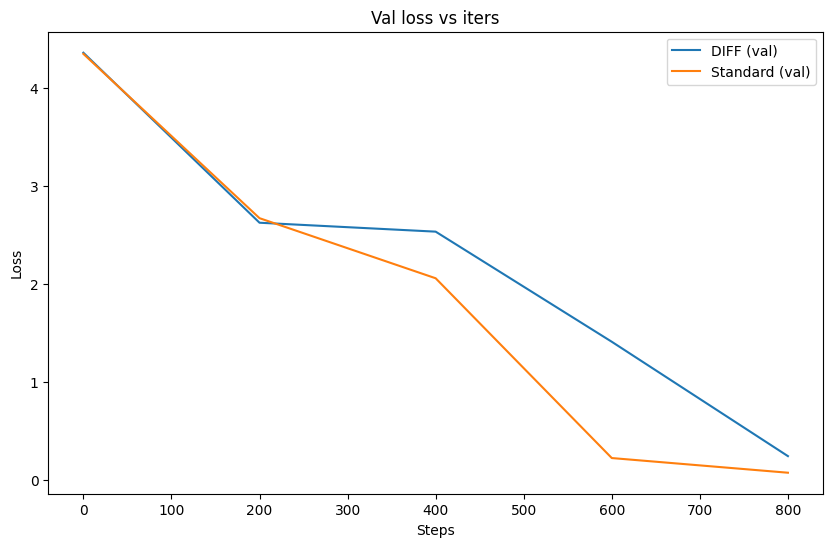

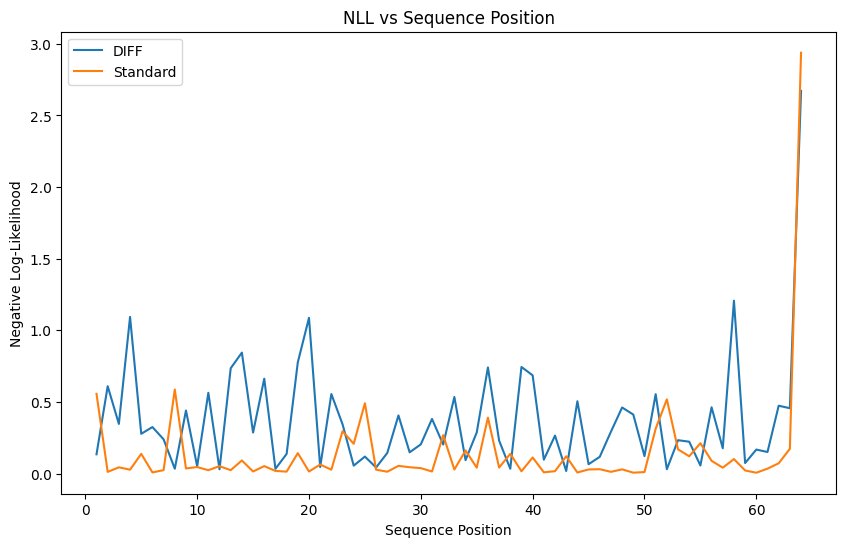

In [79]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
batch_size = 12
block_size = 64
max_iters = 1000
eval_interval = 200
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 1
n_embd = 128
n_head = 4
n_layer = 4
dropout = 0.2

# Load and preprocess data
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

# Multi-head Differential Attention
class MultiHeadDiffAttention(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.head_size = n_embd // n_head
        self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias=False)
        self.c_proj = nn.Linear(n_embd, n_embd, bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        self.lambda_param = nn.Parameter(torch.tensor(0.8))

    def forward(self, x):
        B, T, C = x.shape
        q, k, v = self.c_attn(x).split(self.head_size * self.n_head, dim=2)
        q = q.view(B, T, self.n_head, self.head_size).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_size).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_size).transpose(1, 2)

        q1, q2 = q.chunk(2, dim=-1)
        k1, k2 = k.chunk(2, dim=-1)

        att1 = (q1 @ k1.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(k1.size(-1))))
        att2 = (q2 @ k2.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(k2.size(-1))))
        
        att1 = F.softmax(att1, dim=-1)
        att2 = F.softmax(att2, dim=-1)
        
        att = att1 - self.lambda_param * att2
        att = self.attn_dropout(att)
        
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

# Traditional Multi-head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.head_size = n_embd // n_head
        self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias=False)
        self.c_proj = nn.Linear(n_embd, n_embd, bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        q, k, v = self.c_attn(x).split(self.head_size * self.n_head, dim=2)
        q = q.view(B, T, self.n_head, self.head_size).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_size).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_size).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(k.size(-1))))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

# MLP
class MLP(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd, bias=False)
        self.c_proj  = nn.Linear(4 * n_embd, n_embd, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = F.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

# Transformer Block
class Block(nn.Module):
    def __init__(self, n_embd, n_head, attention_class):
        super().__init__()
        self.ln_1 = nn.LayerNorm(n_embd)
        self.attn = attention_class(n_embd, n_head)
        self.ln_2 = nn.LayerNorm(n_embd)
        self.mlp = MLP(n_embd)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, n_embd, n_head, n_layer, block_size, attention_class):
        super().__init__()
        self.block_size = block_size
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(vocab_size, n_embd),
            wpe = nn.Embedding(block_size, n_embd),
            drop = nn.Dropout(dropout),
            h = nn.ModuleList([Block(n_embd, n_head, attention_class) for _ in range(n_layer)]),
            ln_f = nn.LayerNorm(n_embd),
        ))
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
        self.n_layer = n_layer
        self.n_embd = n_embd

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)
        
        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# MFU 
def compute_mfu(model, fwdbwd_per_iter, dt):
    N = sum(p.numel() for p in model.parameters())
    L, H, Q, T = model.n_layer, model.n_embd, model.n_embd, model.block_size
    flops_per_token = 6*N + 12*L*H*T
    flops_per_fwdbwd = flops_per_token * T
    flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
    flops_achieved = flops_per_iter * (1.0/dt) # per second
    flops_promised = 7e12 # A100 GPU
    mfu = flops_achieved / flops_promised
    return mfu

# Train and eval 
@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def train_model(model, model_type):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    losses = []
    val_losses = []
    
    t0 = time.time()
    for iter in range(max_iters):
        if iter % eval_interval == 0:
            loss_dict = estimate_loss(model)
            print(f"step {iter}: train loss {loss_dict['train']:.4f}, val loss {loss_dict['val']:.4f}")
            losses.append(loss_dict['train'])
            val_losses.append(loss_dict['val'])

        xb, yb = get_batch('train')

        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if iter % 1 == 0:
            t1 = time.time()
            dt = t1 - t0
            t0 = t1
            lossf = loss.item()
            mfu = compute_mfu(model, 1, dt)
            print(f"iter {iter}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {mfu*100:.2f}%")

    # Save checkpoint
    checkpoint_dir = 'checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"{model_type}_model.pt"))

    return losses, val_losses

# Init models
diff_model = TransformerModel(vocab_size, n_embd, n_head, n_layer, block_size, MultiHeadDiffAttention).to(device)
standard_model = TransformerModel(vocab_size, n_embd, n_head, n_layer, block_size, MultiHeadAttention).to(device)

# Train
print("Training DIFF Transformer")
diff_losses, diff_val_losses = train_model(diff_model, "DIFF")

print("\nTraining Standard Transformer")
standard_losses, standard_val_losses = train_model(standard_model, "Standard")

# Sample
def sample(model, model_type):
    context = torch.zeros((1, 1), dtype=torch.long, device=device)
    print(f"\nGenerated text from {model_type} Transformer:")
    print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))

def plot_nll_vs_position():
    plt.figure(figsize=(10, 6))
    for model, model_type in [(diff_model, 'DIFF'), (standard_model, 'Standard')]:
        nll = []
        for pos in range(block_size):
            x, y = get_batch('val')
            with torch.no_grad():
                logits, _ = model(x)
                loss = F.cross_entropy(logits[:, pos, :], y[:, pos], reduction='mean')
            nll.append(loss.item())
        plt.plot(range(1, block_size+1), nll, label=model_type)
    plt.xlabel('Sequence Position')
    plt.ylabel('Negative Log-Likelihood')
    plt.title('NLL vs Sequence Position')
    plt.legend()
    plt.show()
    plt.close()

def plot_training_curves():
    plt.figure(figsize=(10, 6))
    plt.plot(range(0, max_iters, eval_interval), diff_val_losses, label='DIFF (val)')
    plt.plot(range(0, max_iters, eval_interval), standard_val_losses, label='Standard (val)')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Val loss vs iters')
    plt.legend()
    plt.show()
    plt.close()

sample(diff_model, "DIFF")
sample(standard_model, "Standard")
plot_training_curves()
plot_nll_vs_position()
